<h1>Airbnb listing data for NYC 2019</h1>

<p>Airbnb is one of the largest short-term rental services in the world.  As such, they have millions of listings, many of which are in metropolitan areas like LA and NYC.  They currently do not have a public API to get listing data, but fortunately a recent <a href=https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data>dataset</a> is available on Kaggle specifically for NYC, and the raw source for this data can be found <a href="http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/listings.csv.gz">here</a>.  Data for other cities can also be found <a href="http://insideairbnb.com/get-the-data.html">here</a>.</p>

<p>Let's take a look at the <b>listings.csv</b> first, then we'll get to the time series data in <b>calendar.csv</b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
listings_df = pd.read_csv('listings.csv')

/Users/blai/miniconda3/envs/capstone/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (61,62,94,95) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<br/>
<p>There are certain columns that have mixed data. Lets take a look at the general structure of the listings as well as those columns.</p>

In [2]:
print(listings_df.info())
print(listings_df.columns)
for col_index in [60, 61, 93, 94]:
    print(listings_df.columns[col_index])
listings_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Columns: 106 entries, id to reviews_per_month
dtypes: float64(22), int64(21), object(63)
memory usage: 40.9+ MB
None
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)
price
weekly_price
requires_license
license


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2595,https://www.airbnb.com/rooms/2595,20191204162729,2019-12-07,Skylit Midtown Castle,"Beautiful, spacious skylit studio in the heart...","- Spacious (500+ft²), immaculate and nicely fu...","Beautiful, spacious skylit studio in the heart...",none,Centrally located in the heart of Manhattan ju...,...,f,f,strict_14_with_grace_period,t,t,1,1,0,0,0.39
1,3831,https://www.airbnb.com/rooms/3831,20191204162729,2019-12-07,Cozy Entire Floor of Brownstone,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Greetings! We own a double-duplex brownst...,Urban retreat: enjoy 500 s.f. floor in 1899 br...,none,Just the right mix of urban center and local n...,...,f,f,moderate,f,f,1,1,0,0,4.67
2,5099,https://www.airbnb.com/rooms/5099,20191204162729,2019-12-06,Large Cozy 1 BR Apartment In Midtown East,My large 1 bedroom apartment has a true New Yo...,I have a large 1 bedroom apartment centrally l...,My large 1 bedroom apartment has a true New Yo...,none,My neighborhood in Midtown East is called Murr...,...,f,f,moderate,t,t,1,1,0,0,0.60
3,5121,https://www.airbnb.com/rooms/5121,20191204162729,2019-12-06,BlissArtsSpace!,NaN,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,HELLO EVERYONE AND THANKS FOR VISITING BLISS A...,none,NaN,...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,0.38
4,5178,https://www.airbnb.com/rooms/5178,20191204162729,2019-12-05,Large Furnished Room Near B'way,Please don’t expect the luxury here just a bas...,"You will use one large, furnished, private roo...",Please don’t expect the luxury here just a bas...,none,"Theater district, many restaurants around here.",...,f,f,strict_14_with_grace_period,f,f,1,0,1,0,3.52


In [3]:
pd.isna(listings_df.review_scores_rating).sum()

11162

<br/>
<p>As we will see later, those mixed columns are not necessary.  There are also more entries than in the first dataset that we looked at (hopefully for more accurate modeling).  Let's drop the mixed columns and other columns that have irrelevant data, majority incomplete data, or data that can be found in other tables.</p>

In [4]:
# calendar values scraped in a small window between 2019-12-04 and 2019-12-07

listings_clean = listings_df.drop(['listing_url', 'scrape_id', 'last_scraped', 'name', 'space', \
    'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', \
    'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', \
    'host_name', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', \
    'host_acceptance_rate', 'host_since', 'host_listings_count', 'host_total_listings_count', \
    'host_verifications', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_has_profile_pic', \
    'host_identity_verified', 'host_neighbourhood', 'street', 'neighbourhood', 'city', 'state', 'zipcode', \
    'market', 'smart_location', 'country_code', 'country', 'is_location_exact', 'instant_bookable', \
    'is_business_travel_ready', 'license', 'jurisdiction_names', 'review_scores_value', 'requires_license', \
    'review_scores_communication', 'bed_type', 'weekly_price', 'monthly_price', \
    'security_deposit', 'guests_included', 'minimum_minimum_nights', 'maximum_minimum_nights', \
    'minimum_maximum_nights', 'maximum_maximum_nights', 'calendar_updated', 'has_availability', \
    'calendar_last_scraped', 'number_of_reviews_ltm', 'first_review', 'last_review', 'review_scores_accuracy', \
    'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_location', 'cancellation_policy', \
    'require_guest_profile_picture', 'require_guest_phone_verification', 'calculated_host_listings_count', \
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', \
    'calculated_host_listings_count_shared_rooms', 'cleaning_fee', 'extra_people', \
    'square_feet', 'property_type', 'minimum_nights_avg_ntm', \
    'maximum_nights_avg_ntm', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', \
    'availability_60', 'availability_90', 'availability_365'], axis=1)
print(listings_clean.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            50599 non-null  int64  
 1   summary                       48367 non-null  object 
 2   neighbourhood_cleansed        50599 non-null  object 
 3   neighbourhood_group_cleansed  50599 non-null  object 
 4   latitude                      50599 non-null  float64
 5   longitude                     50599 non-null  float64
 6   room_type                     50599 non-null  object 
 7   accommodates                  50599 non-null  int64  
 8   bathrooms                     50548 non-null  float64
 9   bedrooms                      50536 non-null  float64
 10  beds                          50467 non-null  float64
 11  amenities                     50599 non-null  object 
 12  number_of_reviews             50599 non-null  int64  
 13  r

<br/>
<p>Columns <b>bathrooms, bedrooms, beds</b> have missing data, but thankfully not a lot.  We will try to clean that up.  Let's also rename a couple columns</p>

In [5]:
listings_clean.rename(columns={
    'neighbourhood_cleansed':'neighbourhood',
    'neighbourhood_group_cleansed': 'neighbourhood_group'
}, inplace=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50599 entries, 0 to 50598
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    50599 non-null  int64  
 1   summary               48367 non-null  object 
 2   neighbourhood         50599 non-null  object 
 3   neighbourhood_group   50599 non-null  object 
 4   latitude              50599 non-null  float64
 5   longitude             50599 non-null  float64
 6   room_type             50599 non-null  object 
 7   accommodates          50599 non-null  int64  
 8   bathrooms             50548 non-null  float64
 9   bedrooms              50536 non-null  float64
 10  beds                  50467 non-null  float64
 11  amenities             50599 non-null  object 
 12  number_of_reviews     50599 non-null  int64  
 13  review_scores_rating  39437 non-null  float64
 14  reviews_per_month     40379 non-null  float64
dtypes: float64(7), int6

<br/>
<p>Since the large majority of listings are homes/apts or private rooms, let's keep those listings.</p>

In [6]:
print(listings_clean.room_type.value_counts())
listings_clean = listings_clean.loc[
    (listings_clean.room_type == 'Entire home/apt') |
    (listings_clean.room_type == 'Private room')
]

Entire home/apt    26141
Private room       22785
Shared room         1256
Hotel room           417
Name: room_type, dtype: int64


<br/>
<p>We see some possible outliers for <b>accommodates, bathrooms, bedrooms, beds</b>.</p>

In [7]:
listings_clean.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,reviews_per_month
count,4.892600e+04,48926.000000,48926.000000,48926.000000,48879.000000,48863.000000,48798.000000,48926.000000,38259.000000,39182.000000
mean,2.117010e+07,40.728622,-73.950841,2.890161,1.147538,1.187872,1.548260,25.091546,93.968243,1.401085
std,1.242617e+07,0.054921,0.047503,1.910505,0.427225,0.771793,1.124263,47.629989,8.514763,1.670326
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.010000
25%,9.977018e+06,40.689350,-73.982800,2.000000,1.000000,1.000000,1.000000,1.000000,92.000000,0.190000
50%,2.127600e+07,40.722460,-73.955020,2.000000,1.000000,1.000000,1.000000,6.000000,96.000000,0.730000
75%,3.244168e+07,40.762940,-73.934270,4.000000,1.000000,1.000000,2.000000,26.000000,100.000000,2.120000
max,4.058402e+07,40.916860,-73.712990,25.000000,15.500000,21.000000,40.000000,675.000000,100.000000,19.950000


<br/>
<p>Check for duplicate latitude and longitude value pairs, which most likely means duplicate listings</p>

In [8]:
# https://stackoverflow.com/questions/44481768/remove-duplicate-rows-from-pandas-dataframe-where-only-some-columns-have-the-sam
# https://stackoverflow.com/questions/16167829/in-pandas-how-can-i-reset-index-without-adding-a-new-column

listings_clean = listings_clean.drop_duplicates(subset=['latitude', 'longitude']).reset_index(drop=True)
listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48914 entries, 0 to 48913
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    48914 non-null  int64  
 1   summary               46766 non-null  object 
 2   neighbourhood         48914 non-null  object 
 3   neighbourhood_group   48914 non-null  object 
 4   latitude              48914 non-null  float64
 5   longitude             48914 non-null  float64
 6   room_type             48914 non-null  object 
 7   accommodates          48914 non-null  int64  
 8   bathrooms             48867 non-null  float64
 9   bedrooms              48851 non-null  float64
 10  beds                  48786 non-null  float64
 11  amenities             48914 non-null  object 
 12  number_of_reviews     48914 non-null  int64  
 13  review_scores_rating  38249 non-null  float64
 14  reviews_per_month     39172 non-null  float64
dtypes: float64(7), int6

<br/>
<p>Look at non-numerical columns to see if they can be categorized.</p>

In [9]:
# http://benalexkeen.com/mapping-categorical-data-in-pandas/

print(listings_clean.room_type.value_counts())
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())


Entire home/apt    26134
Private room       22780
Name: room_type, dtype: int64
Manhattan        21255
Brooklyn         20194
Queens            5943
Bronx             1149
Staten Island      373
Name: neighbourhood_group, dtype: int64
Williamsburg                  3903
Bedford-Stuyvesant            3823
Harlem                        2691
Bushwick                      2431
Upper West Side               1935
                              ... 
Woodrow                          1
Bay Terrace, Staten Island       1
Fort Wadsworth                   1
Country Club                     1
Willowbrook                      1
Name: neighbourhood, Length: 223, dtype: int64


In [10]:
home_listings = listings_clean.loc[listings_clean.room_type == 'Entire home/apt']
print(home_listings.bedrooms.value_counts())
print(home_listings.beds.value_counts())
print(home_listings.bathrooms.value_counts())

1.0     13018
2.0      6214
0.0      4140
3.0      2034
4.0       476
5.0       133
6.0        41
7.0        17
8.0        10
10.0        5
9.0         4
21.0        1
14.0        1
12.0        1
Name: bedrooms, dtype: int64
1.0     11605
2.0      8097
3.0      3258
4.0      1428
0.0       697
5.0       521
6.0       243
7.0       104
8.0        54
9.0        36
10.0       16
11.0       14
12.0       11
13.0        7
14.0        4
16.0        3
18.0        2
17.0        2
15.0        1
26.0        1
40.0        1
21.0        1
22.0        1
Name: beds, dtype: int64
1.0     22189
2.0      2255
1.5       889
2.5       339
3.0       208
3.5        77
4.0        49
0.0        37
0.5        26
4.5        23
5.0        13
6.0         5
5.5         4
7.0         2
8.0         1
7.5         1
6.5         1
15.5        1
Name: bathrooms, dtype: int64


<p>We see some outliers that may skew any modeling, so let's remove any listing over 10 <b>bedrooms</b>, 12 <b>beds</b>, and 5 <b>bathrooms</b>.  Realistically the vast majority of property owners are not listing super mansions.</p>

In [11]:
listings_clean = listings_clean.loc[
    (listings_clean.bedrooms <= 10) & (listings_clean.beds <=12) & (listings_clean.bathrooms <= 5)
]

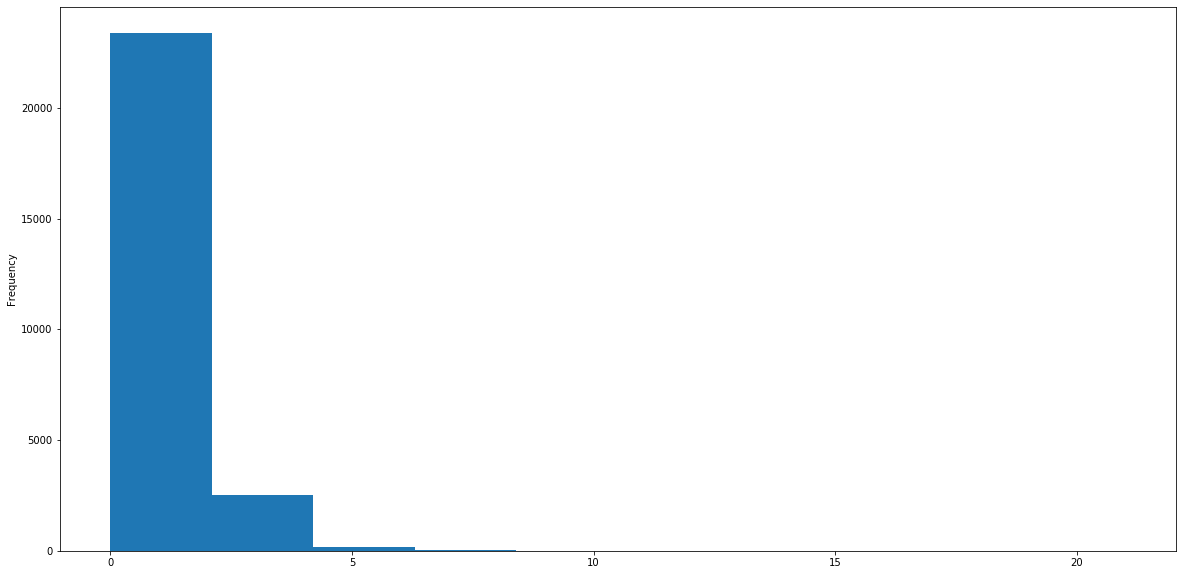

In [12]:
home_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>Home listings are heavily skewed toward single bedroom.  Perhaps we can approximate <b>bedrooms, bathrooms, beds</b> as exponential distributions.</p>
<p>Let's do the same analysis for single room type listings</p>

In [13]:
room_listings = listings_clean.loc[listings_clean.room_type != 'Entire home/apt']
print(room_listings.bedrooms.value_counts())
print(room_listings.beds.value_counts())
print(room_listings.bathrooms.value_counts())

1.0    21426
2.0      563
0.0      457
3.0      123
4.0       44
6.0       11
5.0        7
8.0        1
Name: bedrooms, dtype: int64
1.0     19078
2.0      2295
0.0       656
3.0       409
4.0       134
5.0        28
6.0        16
7.0         8
8.0         4
11.0        1
10.0        1
9.0         1
12.0        1
Name: beds, dtype: int64
1.0    18950
2.0     1708
1.5     1483
3.0      151
2.5      132
0.0       75
0.5       74
4.0       41
3.5       13
5.0        4
4.5        1
Name: bathrooms, dtype: int64


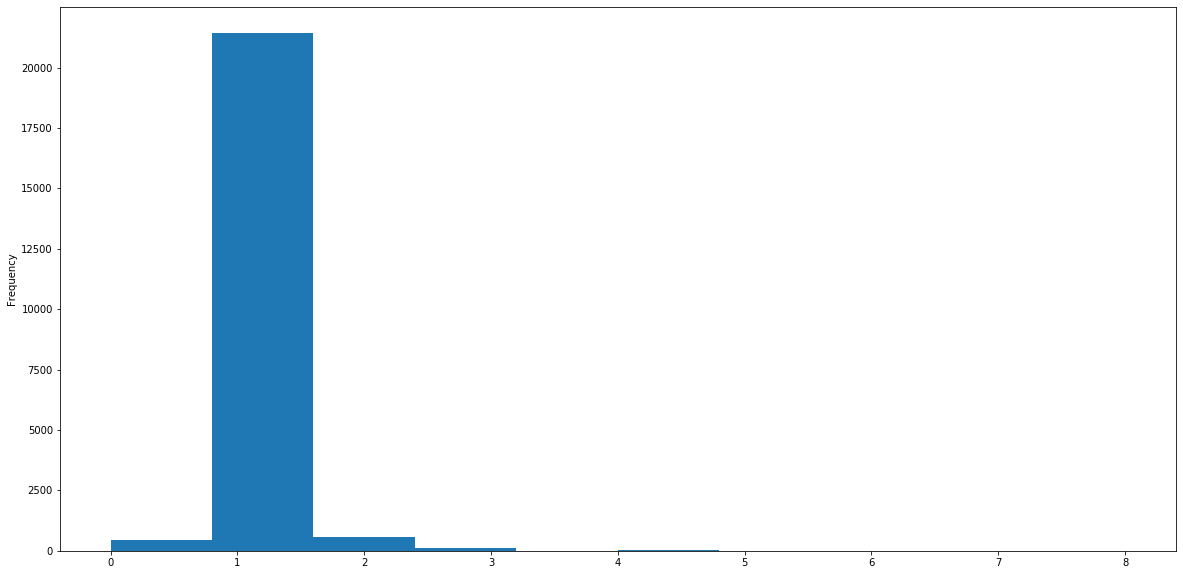

In [14]:
room_listings.bedrooms.plot(kind='hist', figsize=(20, 10))

<p>We get similar results to home listings, which is odd.  Perhaps some single room type listings were incorrectly listed.  That means we may not be able to rely on <b>room_type</b> as a factor in filling in any missing bedroom and bathroom values.</p>

<p>Let's do some data cleaning by filling in the missing <b>bedrooms, bathrooms, beds</b> values (disregarding homes/apts vs. single room since <b>room_type</b> is not always indicative of multiple rooms vs. one room).  0 values can still be considered valid (e.g. studio apt, shared living area, shared bathroom, non-bed type sleeping arrangment).  We will assume that 0.001 degree latitude or longitude <a href=https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162">is about 100 m</a>.  Let's average over an area of 200 m radius from listings that have missing data.  We will group by <b>neighbourhood</b> when calculating the mean.</p>

In [15]:
lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors(row, col_name, col_index):
    item = row[col_index]
    room_type = row[5]
    lat = row[3]
    long = row[4]
    if math.isnan(item):
        item = listings_clean[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_clean.latitude < lat + lat_diff) \
            & (listings_clean.longitude > long - long_diff) \
            & (listings_clean.longitude < long + long_diff)].groupby(by=listings_clean.neighbourhood).mean().round()[0]
        row[col_index] = item
    return row

listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bathrooms', col_index=7, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='bedrooms', col_index=8, axis=1)
listings_clean = listings_clean.apply(avg_of_neighbors, col_name='beds', col_index=9, axis=1)

In [16]:
print(listings_clean.bedrooms.value_counts())
print(listings_clean.bathrooms.value_counts())
print(listings_clean.beds.value_counts())

1.0     34418
2.0      6771
0.0      4593
3.0      2152
4.0       518
5.0       131
6.0        46
7.0        13
8.0         8
10.0        2
9.0         2
Name: bedrooms, dtype: int64
1.0    41080
2.0     3960
1.5     2372
2.5      467
3.0      354
0.0      110
0.5      100
3.5       88
4.0       85
4.5       24
5.0       14
Name: bathrooms, dtype: int64
1.0     30644
2.0     10381
3.0      3667
4.0      1562
0.0      1353
5.0       546
6.0       258
7.0       112
8.0        57
9.0        36
11.0       15
10.0       14
12.0        9
Name: beds, dtype: int64


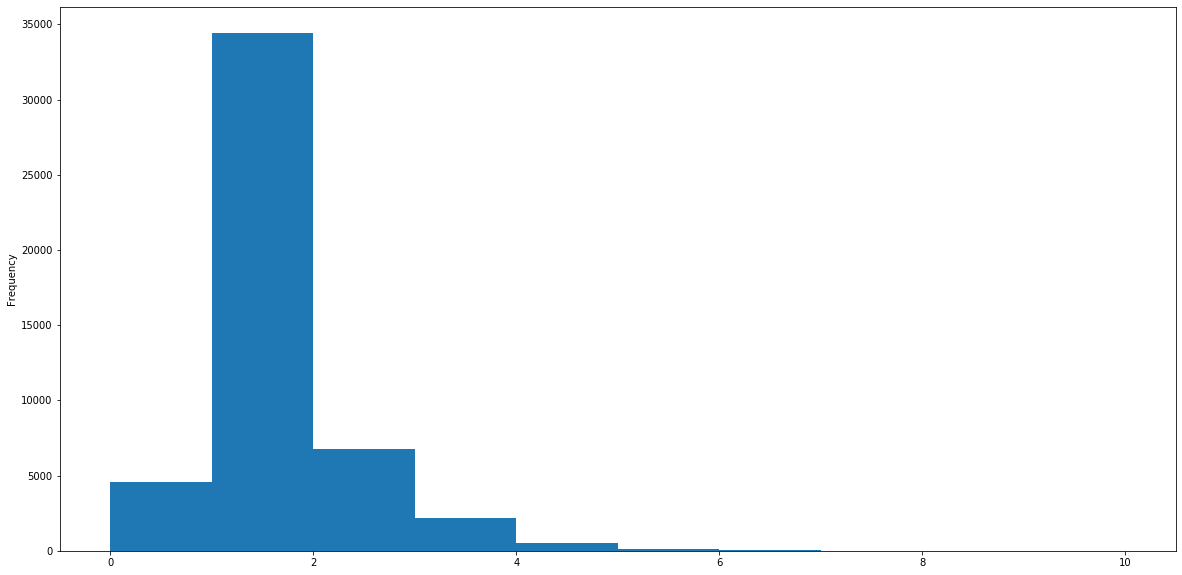

In [17]:
listings_clean.bedrooms.plot(kind='hist', figsize=(20, 10))

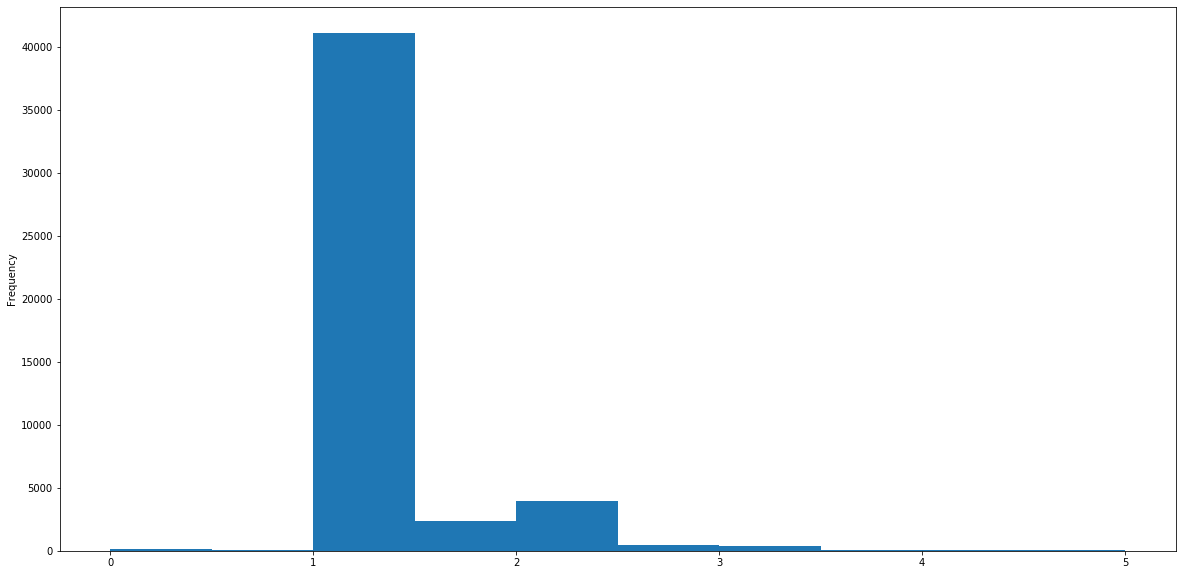

In [18]:
listings_clean.bathrooms.plot(kind='hist', figsize=(20, 10))

<p>After <b>bedrooms, bathrooms, beds</b> cleanup, we are able to see a bit more detail in the distributions.  They are approximately exponential (again skewed toward 1).</p>

<p>Final check on the listings for any missing data.</p>

In [19]:
listings_clean.info()
print(listings_clean.neighbourhood_group.value_counts())
print(listings_clean.neighbourhood.value_counts())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48654 entries, 0 to 48913
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    48654 non-null  int64  
 1   summary               46577 non-null  object 
 2   neighbourhood         48654 non-null  object 
 3   neighbourhood_group   48654 non-null  object 
 4   latitude              48654 non-null  float64
 5   longitude             48654 non-null  float64
 6   room_type             48654 non-null  object 
 7   accommodates          48654 non-null  int64  
 8   bathrooms             48654 non-null  float64
 9   bedrooms              48654 non-null  float64
 10  beds                  48654 non-null  float64
 11  amenities             48654 non-null  object 
 12  number_of_reviews     48654 non-null  int64  
 13  review_scores_rating  38120 non-null  float64
 14  reviews_per_month     39034 non-null  float64
dtypes: float64(7), int6

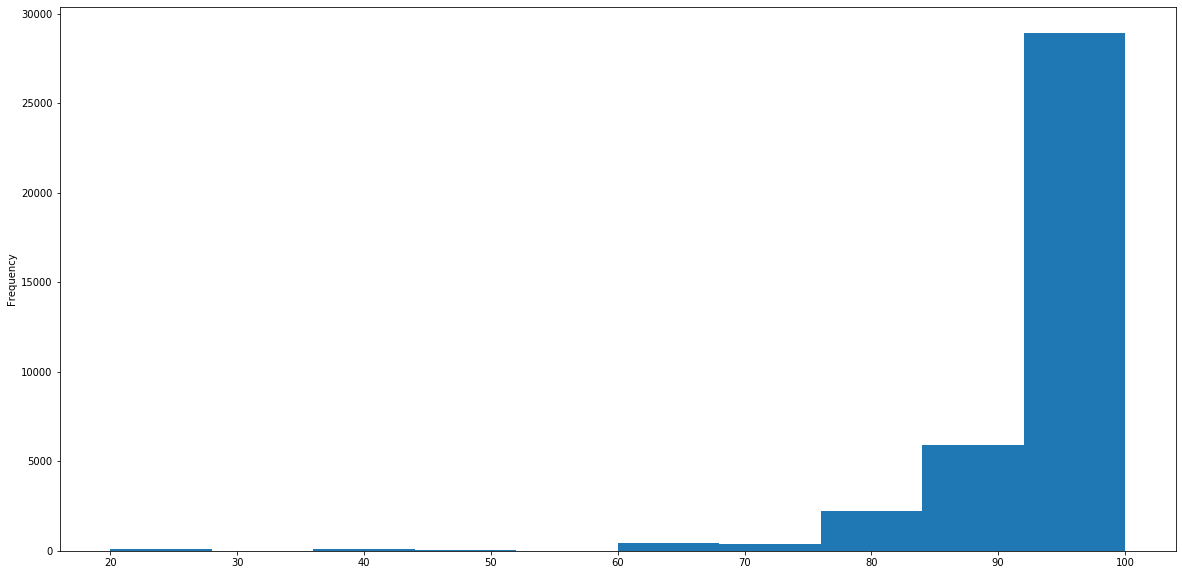

In [20]:
listings_clean.review_scores_rating.plot(kind='hist', figsize=(20, 10))

In [21]:
listings_clean['review_scores_rating'].fillna(listings_clean.review_scores_rating.mean(), inplace=True)

<p>One hot encode the <b>neighbourhood</b> values.  Drop non-numerical columns as well as listing IDs (which do not have any meaning for modeling).  Also convert <b>room_type</b> to 1 and 0 valued <b>entire_home_apt</b>.</p>

In [22]:
def cleanup_neighbourhood(val):
    return val.replace(' ', '_').lower()

listings_clean['neighbourhood_group'] = listings_clean.neighbourhood_group.apply(cleanup_neighbourhood)
neighbourhood_one_hot = pd.get_dummies(listings_clean.neighbourhood_group)
listings_clean = listings_clean.join(neighbourhood_one_hot)

In [23]:
listings_clean['entire_home_apt'] = np.where(listings_clean.room_type == 'Entire home/apt', 1, 0)

In [24]:
import string

def cleanup_amenities(text):
    remove = string.punctuation
    remove = remove.replace("-", "").replace(",", "").replace("/", "")
    text = text.lower().translate({ord(char): None for char in remove})
    text = text.replace("translation missing enhostingamenity49", "")
    text = text.replace("translation missing enhostingamenity50", "")
    text = text.replace(",,", ",").replace("’", "").replace(' / ', ' ').replace('/', ' ')
    text = text.replace(' ', '_').replace('-', '_')
    return text.split(",")

listings_clean['amenities'] = listings_clean['amenities'].apply(cleanup_amenities)

In [25]:
amenities_sparse = listings_clean.amenities.str.join('|').str.get_dummies()
listings_clean = listings_clean.join(amenities_sparse)

In [60]:
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

remove = string.punctuation

def tokenize_summary(text):
    
    text = str(text)
    text = text.lower().translate({ord(char): None for char in remove})
    text = re.sub(r'\d+', '', text)
    text = lemmatizer.lemmatize(text)
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words and re.sub('[\W_]+', '', w)]

listings_clean['summary_tokenized'] = listings_clean['summary'].apply(tokenize_summary)

[nltk_data] Downloading package punkt to /Users/blai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/blai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/blai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [107]:
import re
from nltk.tokenize import word_tokenize, punkt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
stop_words = stop_words + ['ps', 'hello', 'go', 'everyone', 's', 'sf', 'nt', 'pmam', 'wown', 'see']
lemmatizer = WordNetLemmatizer()

def tokenize_summary(text):
    text = re.sub(r'\d+', '', str(text))
    tokens = word_tokenize(text)
    tokens = list(filter(lambda token: punkt.PunktToken(token).is_non_punct, tokens))
    tokens = [token.translate({ord(char): None for char in remove}) for token in tokens]
    tokens = [token.lower() for token in tokens]
    tokens = list(filter(lambda token: token not in stop_words, tokens))
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

text = listings_clean.summary[11]

tokenize_summary(text)

[nltk_data] Downloading package punkt to /Users/blai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/blai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/blai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['streetlevel',
 'floor',
 'story',
 'brownstone',
 'residential',
 'street',
 'live',
 'upstairs',
 'private',
 'entrance',
 'stair',
 'lead',
 'main',
 'house',
 'behind',
 'door',
 'enter',
 'bedroom',
 'bathroom',
 'living',
 'room',
 'kitchenette',
 'cook',
 'upstairs',
 'kitchen',
 'seldom',
 'use',
 'garden',
 'access',
 'big',
 'tv',
 'internet',
 'note',
 'bathroom',
 'en',
 'suite',
 'additional',
 'guest',
 'must',
 'walk',
 'bedroom',
 'use',
 'doorman',
 'available',
 'dropdown']

In [61]:
summary_tokenized = listings_clean.iloc[:1000,:].summary_tokenized.str.join('|').str.get_dummies()
print("Number of features from tokenized listing summaries:", len(summary_tokenized.columns))
for c in summary_tokenized.columns:
    print(c)

# listings_clean = listings_clean.join(summary_tokenized)

Number of features from tokenized listing summaries: 3339
abc
abcd
able
abraco
absolute
absolutely
abundance
abundant
ac
accents
accept
acceptable
accepted
accepts
access
accessible
acclaimed
accommodate
accommodates
accommodating
accommodation
accommodations
accomodate
accomodated
accurate
ace
acres
across
action
active
activities
actor
actual
actually
ad
add
added
addition
additional
addl
adds
adjacent
adjoining
adorable
adore
adult
adults
advance
adventure
adventurer
adventurers
advertised
advice
aero
aesthetic
aesthetics
affordable
afraid
age
agree
ah
air
airbnb
airbnbs
airco
airconditioned
airconditioning
airheat
airly
airport
airports
airy
aka
al
alcove
alexa
alike
allergic
allergies
allow
allowed
allowing
allows
almost
alone
along
alphabet
also
alternative
always
amazing
ambiance
ambience
amenities
america
american
amidst
among
amongst
amount
ample
ampm
anchored
andor
animator
animent
anne
another
answer
answers
antiques
anyone
anything
anytime
anywhere
apartament
apartment
apar

<br/>
<p>Now let's take a look at the time series data for availability, price, and nights.  <a href=http://data.insideairbnb.com/united-states/ny/new-york-city/2019-12-04/data/calendar.csv.gz><b>Calendar.csv</b></a> comes from the same <a href="http://insideairbnb.com/get-the-data.html">source</a> as <b>listings.csv</b></p>.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline
calendar_df = pd.read_csv('calendar.csv', parse_dates=['date'])

<br/>
<p>This time we don't have to deal with columns of mixed data, nor do we have a large number of columns like in the <b>listings_clean</b> table.  We do, however, have over 18 million entries, which makes sense given that this is time series data over a year for 50,000+ listings.  We will have to clean up availability and price.</p>

In [27]:
print(calendar_df.info())
print(calendar_df.columns)
calendar_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18470156 entries, 0 to 18470155
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 986.4+ MB
None
Index(['listing_id', 'date', 'available', 'price', 'adjusted_price',
       'minimum_nights', 'maximum_nights'],
      dtype='object')


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,19812,2019-12-05,f,$105.00,$105.00,3.0,90.0
1,2595,2019-12-06,f,$175.00,$175.00,10.0,1125.0
2,2595,2019-12-07,f,$175.00,$175.00,10.0,1125.0
3,2595,2019-12-08,f,$175.00,$175.00,10.0,1125.0
4,2595,2019-12-09,f,$175.00,$175.00,10.0,1125.0


<br/>
<p>On checking for equal distribution of all listings over the relevant time period (assumed for this step to be a year), we see a problem with <b>listing_id</b> 15268792.  Let's just remove it, since it is not worth the effort to build a year's worth of data for that one listing.</p>

In [28]:
print(calendar_df.listing_id.value_counts())
calendar_clean = calendar_df[calendar_df.listing_id != 15268792]


25512622    368
32678719    368
28138840    368
30069091    368
24285044    368
           ... 
27926502    365
18992796    365
21677053    365
30226855    365
15268792      6
Name: listing_id, Length: 50599, dtype: int64


<br/>
<p>Since this data set was captured in 2019, we must clean up dates that have year 2020.  Then drop any duplicate <b>listing_id, date</b> combos.  Then check that all days add up to a calendar year for each <b>listing_id</b>.</p>

In [29]:
# https://stackoverflow.com/questions/50674011/replace-the-year-in-pandas-datetime-column
# https://stackoverflow.com/questions/28773342/truncate-timestamp-column-to-hour-precision-in-pandas-dataframe

calendar_clean['date'] = calendar_clean['date'].mask(calendar_clean['date'].dt.year == 2020,
                            calendar_clean['date'] - pd.to_timedelta(365, unit='D') + pd.to_timedelta(12, unit='h'))
calendar_clean['date'] = calendar_clean['date'].dt.floor('D')

/Users/blai/miniconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/blai/miniconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [30]:
calendar_clean = calendar_clean.drop_duplicates(subset=['listing_id', 'date']).reset_index(drop=True)
print(calendar_clean.listing_id.value_counts())

327521      365
7756711     365
31877537    365
14961122    365
201992      365
           ... 
37055580    365
13186007    365
18549136    365
34646244    365
30226855    365
Name: listing_id, Length: 50598, dtype: int64


<br/>
<p>Verify that all listing_id values can be found in the <b>listings_clean</b> table.  If not, then remove rows with listing_id values don't exist in the other table.</p>

In [31]:
# https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe

ids_match = calendar_clean.listing_id.isin(listings_clean.id)
print(ids_match.value_counts())

True     17758345
False      709925
Name: listing_id, dtype: int64


In [32]:
calendar_clean = calendar_clean[calendar_clean.listing_id.isin(listings_clean.id)]
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17758345 entries, 0 to 18468269
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 1.1+ GB


<br/>
<p>Translate all <b>available</b> values to 1 (available) or 0 (unavailable).</p>

In [33]:
print(calendar_clean.available.value_counts())
calendar_clean['available'] = np.where(calendar_clean.available == 't', 1, 0)
print(calendar_clean.available.value_counts())

f    11990442
t     5767903
Name: available, dtype: int64
0    11990442
1     5767903
Name: available, dtype: int64


<br/>
<p>Less than 1% of the entries have <b>adjusted_price</b> not equal to <b>price</b>, but we will use <b>adjusted_price</b> anyway and clean it up to be numerical</p>

In [34]:
calendar_clean[calendar_clean.price != calendar_clean.adjusted_price]

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
8232,20734,2019-12-06,0,$134.00,$127.00,3.0,29.0
8419,20734,2019-12-07,0,$134.00,$127.00,3.0,29.0
8420,20734,2019-12-08,0,$134.00,$127.00,3.0,29.0
8421,20734,2019-12-09,0,$134.00,$127.00,3.0,29.0
8422,20734,2019-12-10,0,$134.00,$127.00,3.0,29.0
...,...,...,...,...,...,...,...
18402175,40482221,2019-12-01,0,$74.00,$63.00,1.0,365.0
18402176,40482221,2019-12-02,0,$74.00,$63.00,1.0,365.0
18402177,40482221,2019-12-03,0,$74.00,$63.00,1.0,365.0
18402178,40482221,2019-12-04,0,$74.00,$63.00,1.0,365.0


In [35]:
calendar_clean['price_cleansed'] = calendar_clean.adjusted_price\
.str.replace('$', '').str.replace(',', '').astype('float')

In [36]:
calendar_clean = calendar_clean.drop(['adjusted_price', 'price'], axis=1)
calendar_clean.rename(columns={'price_cleansed': 'price'}, inplace=True)

<br/>
<p>Now is a good time to check the state of the table.  All columns except for <b>maximum_nights</b> seem to have useful data.  The large majority of listings allowing over 1000 nights for a short-term rental means that, for practical purposes, it is limitless.</p>

In [37]:
calendar_clean.info()
calendar_clean.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17758345 entries, 0 to 18468269
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   minimum_nights  float64       
 4   maximum_nights  float64       
 5   price           float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 948.4 MB


,listing_id,date,available,minimum_nights,maximum_nights,price
0,19812,2019-12-05,0,3.0,90.0,105.0
1,2595,2019-12-06,0,10.0,1125.0,175.0
2,2595,2019-12-07,0,10.0,1125.0,175.0
3,2595,2019-12-08,0,10.0,1125.0,175.0
4,2595,2019-12-09,0,10.0,1125.0,175.0


In [38]:
calendar_clean.describe()

,listing_id,available,minimum_nights,maximum_nights,price
count,1.775834e+07,1.775834e+07,1.775772e+07,1.775772e+07,1.775745e+07
mean,2.114076e+07,3.247996e-01,8.592398e+00,2.748719e+05,1.560488e+02
std,1.239078e+07,4.682999e-01,3.037026e+01,2.423063e+07,2.568249e+02
min,2.595000e+03,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,9.979270e+06,0.000000e+00,2.000000e+00,2.900000e+01,7.000000e+01
50%,2.125183e+07,0.000000e+00,3.000000e+00,1.125000e+03,1.100000e+02
75%,3.234744e+07,1.000000e+00,5.000000e+00,1.125000e+03,1.800000e+02
max,4.058402e+07,1.000000e+00,3.456000e+03,2.147484e+09,1.000000e+04


In [39]:
calendar_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17758345 entries, 0 to 18468269
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       int64         
 3   minimum_nights  float64       
 4   maximum_nights  float64       
 5   price           float64       
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 948.4 MB


<br/>
<p>Since travel patterns are usually seasonal, let's average availability, min nights required, and price over each season and the whole year.</p>

In [40]:
available_year_avg = calendar_clean.groupby(by='listing_id').available.mean()
available_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id').available.mean()
available_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id').available.mean()
available_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id').available.mean()
available_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id').available.mean()
available_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id').available.mean()
available_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id').available.mean()
available_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id').available.mean()

calendar_averages = pd.DataFrame(available_year_avg)
calendar_averages.rename(columns={'available': 'available_year_avg'}, inplace=True)
calendar_averages['available_winter_avg'] = available_winter_avg
calendar_averages['available_spring_avg'] = available_spring_avg
calendar_averages['available_summer_avg'] = available_summer_avg
calendar_averages['available_fall_avg'] = available_fall_avg
calendar_averages['available_jan_avg'] = available_jan_avg
calendar_averages['available_jun_avg'] = available_jun_avg
calendar_averages['available_dec_avg'] = available_dec_avg


In [41]:
min_nights_year_avg = calendar_clean.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['minimum_nights'].mean()
min_nights_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['minimum_nights'].mean()

calendar_averages['min_nights_year_avg'] = min_nights_year_avg
calendar_averages['min_nights_winter_avg'] = min_nights_winter_avg
calendar_averages['min_nights_spring_avg'] = min_nights_spring_avg
calendar_averages['min_nights_summer_avg'] = min_nights_summer_avg
calendar_averages['min_nights_fall_avg'] = min_nights_fall_avg
calendar_averages['min_nights_jan_avg'] = min_nights_jan_avg
calendar_averages['min_nights_jun_avg'] = min_nights_jun_avg
calendar_averages['min_nights_dec_avg'] = min_nights_dec_avg

In [42]:
price_year_avg = calendar_clean.groupby(by='listing_id')['price'].mean()
price_winter_avg = calendar_clean[(calendar_clean.date.dt.month == 1) | (calendar_clean.date.dt.month == 2) \
    | (calendar_clean.date.dt.month == 12)].groupby(by='listing_id')['price'].mean()
price_spring_avg = calendar_clean[(calendar_clean.date.dt.month >= 3) & (calendar_clean.date.dt.month <= 5)]\
.groupby(by='listing_id')['price'].mean()
price_summer_avg = calendar_clean[(calendar_clean.date.dt.month >= 6) & (calendar_clean.date.dt.month <= 8)]\
.groupby(by='listing_id')['price'].mean()
price_fall_avg = calendar_clean[(calendar_clean.date.dt.month >= 9) & (calendar_clean.date.dt.month <= 11)]\
.groupby(by='listing_id')['price'].mean()
price_jan_avg = calendar_clean[calendar_clean.date.dt.month == 1].groupby(by='listing_id')['price'].mean()
price_jun_avg = calendar_clean[calendar_clean.date.dt.month == 6].groupby(by='listing_id')['price'].mean()
price_dec_avg = calendar_clean[calendar_clean.date.dt.month == 12].groupby(by='listing_id')['price'].mean()

calendar_averages['price_year_avg'] = price_year_avg
calendar_averages['price_winter_avg'] = price_winter_avg
calendar_averages['price_spring_avg'] = price_spring_avg
calendar_averages['price_summer_avg'] = price_summer_avg
calendar_averages['price_fall_avg'] = price_fall_avg
calendar_averages['price_jan_avg'] = price_jan_avg
calendar_averages['price_jun_avg'] = price_jun_avg
calendar_averages['price_dec_avg'] = price_dec_avg

In [43]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48653 entries, 2595 to 40584021
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   available_year_avg     48653 non-null  float64
 1   available_winter_avg   48653 non-null  float64
 2   available_spring_avg   48653 non-null  float64
 3   available_summer_avg   48653 non-null  float64
 4   available_fall_avg     48653 non-null  float64
 5   available_jan_avg      48653 non-null  float64
 6   available_jun_avg      48653 non-null  float64
 7   available_dec_avg      48653 non-null  float64
 8   min_nights_year_avg    48653 non-null  float64
 9   min_nights_winter_avg  48653 non-null  float64
 10  min_nights_spring_avg  48653 non-null  float64
 11  min_nights_summer_avg  48653 non-null  float64
 12  min_nights_fall_avg    48653 non-null  float64
 13  min_nights_jan_avg     48653 non-null  float64
 14  min_nights_jun_avg     48653 non-null  float64
 

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,48653.000000,48653.000000,48653.000000,48653.000000,48653.000000,48653.000000,48653.000000,48653.000000,48653.000000,48653.000000,...,48653.000000,48653.000000,48653.000000,48653.000000,48651.000000,48653.000000,48650.000000,48651.000000,48653.000000,48653.000000
mean,0.324800,0.367686,0.366178,0.292422,0.273285,0.416534,0.292684,0.239441,8.592328,8.046683,...,8.853276,7.725376,156.048575,149.758814,155.145125,157.516932,161.701132,146.408156,158.008192,156.069265
std,0.371980,0.368098,0.447648,0.440315,0.440492,0.444207,0.438403,0.294223,28.881280,25.667699,...,33.876058,23.435944,236.460285,228.505797,236.534638,233.831249,291.482058,228.250163,234.747373,234.521394
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.991781,1.966667,...,2.000000,1.903226,70.000000,69.000000,70.000000,70.000000,70.000000,67.903226,70.000000,70.000000
50%,0.167123,0.266667,0.043478,0.000000,0.000000,0.129032,0.000000,0.129032,3.000000,3.000000,...,3.000000,3.000000,110.000000,108.166667,110.000000,110.673913,110.000000,105.000000,110.666667,110.516129
75%,0.665753,0.722222,1.000000,0.956522,0.989011,0.935484,1.000000,0.419355,5.000000,5.000000,...,5.000000,5.000000,180.000000,175.000000,180.000000,181.000000,180.000000,170.000000,181.100000,180.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1494.104110,1997.166667,...,3337.000000,1574.225806,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000


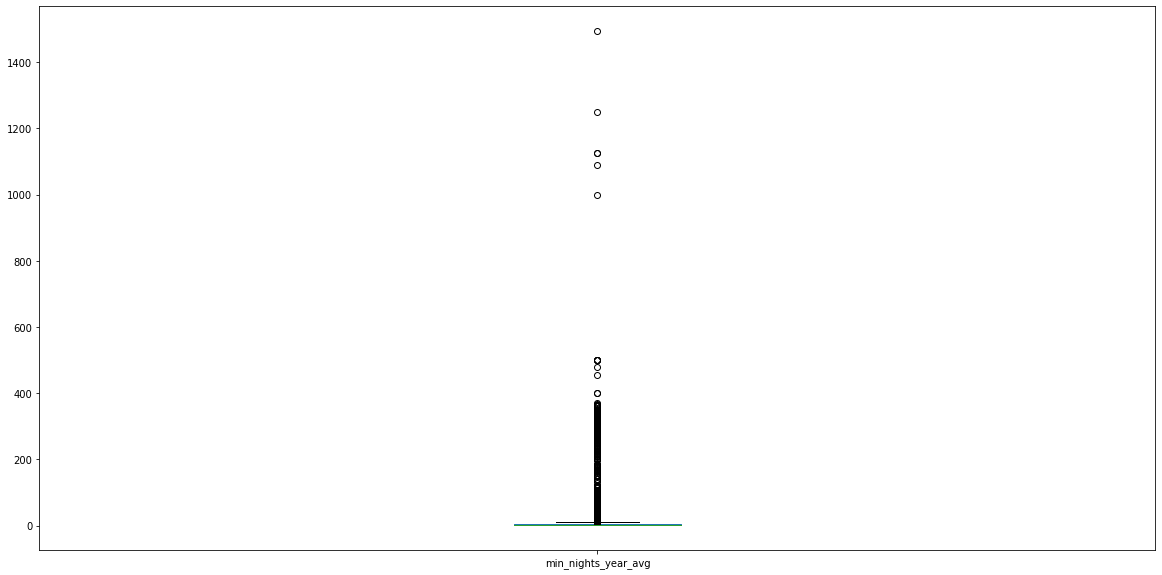

In [44]:
calendar_averages.min_nights_year_avg.plot(kind='box', figsize=(20, 10))

<p>1000+ <b>minimum_nights</b> is extremely high and unrealistic.  Box plot shows outliers above 10 nights, and the 3rd quartile level is 5 nights.</p>

<p>Let's drop any entry that averages over 30 minimum nights.</p>

In [45]:
calendar_averages = calendar_averages.loc[
    (calendar_averages.min_nights_year_avg <= 30) & 
    (calendar_averages.min_nights_winter_avg <= 30) &
    (calendar_averages.min_nights_spring_avg <= 30) &
    (calendar_averages.min_nights_summer_avg <= 30) &
    (calendar_averages.min_nights_fall_avg <= 30) &
    (calendar_averages.min_nights_jan_avg <= 30) &
    (calendar_averages.min_nights_jun_avg <= 30) &
    (calendar_averages.min_nights_dec_avg <= 30)
]

<br/>
<p>The box plot shows clear outliers above \$1000 average nightly price, and the 3rd quartile level is \$180.  Let's drop all listings above \$1000</p>

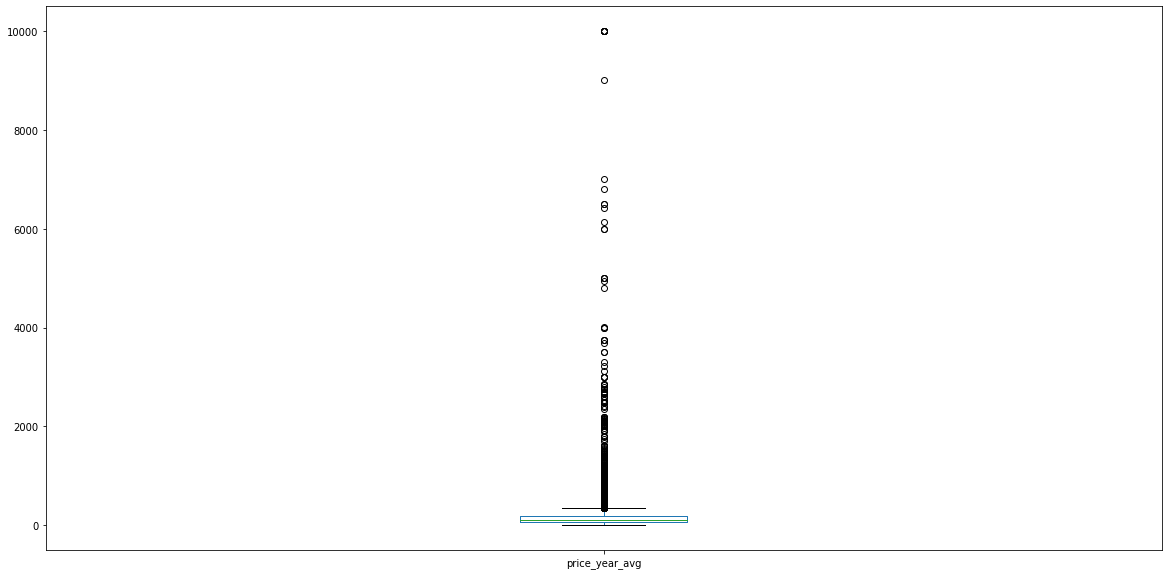

In [46]:
calendar_averages.price_year_avg.plot(kind='box', figsize=(20, 10))

In [47]:
calendar_averages = calendar_averages.loc[
    (calendar_averages.price_year_avg <= 1000) &
    (calendar_averages.price_winter_avg <= 1000) &
    (calendar_averages.price_spring_avg <= 1000) &
    (calendar_averages.price_summer_avg <= 1000) &
    (calendar_averages.price_fall_avg <= 1000) &
    (calendar_averages.price_jan_avg <= 1000) &
    (calendar_averages.price_jun_avg <= 1000) &
    (calendar_averages.price_dec_avg <= 1000)
]

In [48]:
calendar_averages.info()
calendar_averages.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47134 entries, 2595 to 40584021
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   available_year_avg     47134 non-null  float64
 1   available_winter_avg   47134 non-null  float64
 2   available_spring_avg   47134 non-null  float64
 3   available_summer_avg   47134 non-null  float64
 4   available_fall_avg     47134 non-null  float64
 5   available_jan_avg      47134 non-null  float64
 6   available_jun_avg      47134 non-null  float64
 7   available_dec_avg      47134 non-null  float64
 8   min_nights_year_avg    47134 non-null  float64
 9   min_nights_winter_avg  47134 non-null  float64
 10  min_nights_spring_avg  47134 non-null  float64
 11  min_nights_summer_avg  47134 non-null  float64
 12  min_nights_fall_avg    47134 non-null  float64
 13  min_nights_jan_avg     47134 non-null  float64
 14  min_nights_jun_avg     47134 non-null  float64
 

,available_year_avg,available_winter_avg,available_spring_avg,available_summer_avg,available_fall_avg,available_jan_avg,available_jun_avg,available_dec_avg,min_nights_year_avg,min_nights_winter_avg,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,...,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000
mean,0.315787,0.362074,0.357377,0.281152,0.262978,0.411281,0.281733,0.233611,5.613992,5.601135,...,5.618383,5.558512,143.415385,138.550276,143.596339,145.940632,145.491091,135.526033,146.433913,144.300693
std,0.368743,0.366160,0.445082,0.434930,0.435150,0.442726,0.432902,0.289838,8.156074,8.118834,...,8.193094,8.073898,115.492734,110.213401,117.543580,119.136223,118.855416,108.073303,120.722243,116.890244
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.600000,1.700000,...,1.533333,1.645161,70.000000,68.977778,70.000000,70.000000,70.000000,67.870968,70.000000,70.000000
50%,0.153425,0.244444,0.043478,0.000000,0.000000,0.129032,0.000000,0.129032,2.846575,2.722222,...,2.800000,2.709677,110.000000,106.744444,109.315217,110.000000,110.000000,104.354839,110.000000,110.000000
75%,0.624658,0.722222,0.989130,0.902174,0.923077,0.935484,0.933333,0.387097,5.000000,5.000000,...,5.000000,5.000000,177.723288,174.850000,177.000000,180.000000,180.000000,168.983871,180.000000,179.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,30.000000,30.000000,...,30.000000,30.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


<p>We still have to deal with price outliers, but let's merge the <b>calendar_averages</b> and <b>listings_clean</b> tables on listing ID so we can use geographic data to average over nearest neighbors.</p>

In [49]:
# https://chrisalbon.com/python/data_wrangling/pandas_join_merge_dataframe/

listings_clean = listings_clean.loc[listings_clean.id != 15268792]
listings_clean = listings_clean.loc[listings_clean.id.isin(calendar_averages.index)]
listings_merge = pd.merge(listings_clean, calendar_averages, left_on='id', right_index=True)

In [50]:
listings_merge.info()
listings_merge.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47134 entries, 0 to 48913
Columns: 172 entries, id to price_dec_avg
dtypes: float64(31), int64(131), object(5), uint8(5)
memory usage: 60.6+ MB


,id,summary,neighbourhood,neighbourhood_group,latitude,longitude,room_type,accommodates,bathrooms,bedrooms,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
0,2595,"Beautiful, spacious skylit studio in the heart...",Midtown,manhattan,40.75362,-73.98377,Entire home/apt,1,1.0,0.0,...,10.0,10.0,196.334247,177.255556,176.152174,215.728261,216.0,175.000000,215.1,181.548387
1,3831,Urban retreat: enjoy 500 s.f. floor in 1899 br...,Clinton Hill,brooklyn,40.68514,-73.95976,Entire home/apt,3,1.0,1.0,...,1.0,1.0,86.224658,88.911111,86.032609,85.000000,85.0,86.516129,85.0,91.645161
2,5099,My large 1 bedroom apartment has a true New Yo...,Murray Hill,manhattan,40.74767,-73.97500,Entire home/apt,2,1.0,1.0,...,3.0,3.0,206.164384,225.000000,200.000000,200.000000,200.0,216.129032,200.0,256.451613
4,5178,Please don’t expect the luxury here just a bas...,Hell's Kitchen,manhattan,40.76489,-73.98493,Private room,2,1.0,1.0,...,2.0,2.0,78.279452,77.233333,77.869565,79.000000,79.0,76.322581,79.0,79.000000
5,5203,"Our best guests are seeking a safe, clean, spa...",Upper West Side,manhattan,40.80178,-73.96723,Private room,1,1.0,1.0,...,2.0,2.0,78.106849,75.222222,77.163043,80.000000,80.0,75.000000,80.0,75.645161


In [51]:
listings_merge.describe()

,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,reviews_per_month,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.713400e+04,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,38218.000000,...,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000
mean,2.103222e+07,40.728482,-73.950377,2.863920,1.135147,1.173569,1.529618,25.725697,94.000336,1.418428,...,5.618383,5.558512,143.415385,138.550276,143.596339,145.940632,145.491091,135.526033,146.433913,144.300693
std,1.236688e+07,0.055183,0.047725,1.815014,0.386755,0.727232,1.035513,48.180275,7.487219,1.680114,...,8.193094,8.073898,115.492734,110.213401,117.543580,119.136223,118.855416,108.073303,120.722243,116.890244
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.010000,...,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.926413e+06,40.689023,-73.982410,2.000000,1.000000,1.000000,1.000000,1.000000,93.000000,0.190000,...,1.533333,1.645161,70.000000,68.977778,70.000000,70.000000,70.000000,67.870968,70.000000,70.000000
50%,2.109668e+07,40.722285,-73.954680,2.000000,1.000000,1.000000,1.000000,6.000000,94.000000,0.750000,...,2.800000,2.709677,110.000000,106.744444,109.315217,110.000000,110.000000,104.354839,110.000000,110.000000
75%,3.213642e+07,40.763100,-73.933742,4.000000,1.000000,1.000000,2.000000,27.000000,99.000000,2.150000,...,5.000000,5.000000,177.723288,174.850000,177.000000,180.000000,180.000000,168.983871,180.000000,179.000000
max,4.058402e+07,40.916860,-73.712990,16.000000,5.000000,10.000000,12.000000,675.000000,100.000000,19.950000,...,30.000000,30.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


<br/>
<p>Availability seems to be a heavy tailed distribution, with most listings unavailable over the year.  This suggests a high average utilization of rentals in NYC, but there are still a lot of rentals available.</p>

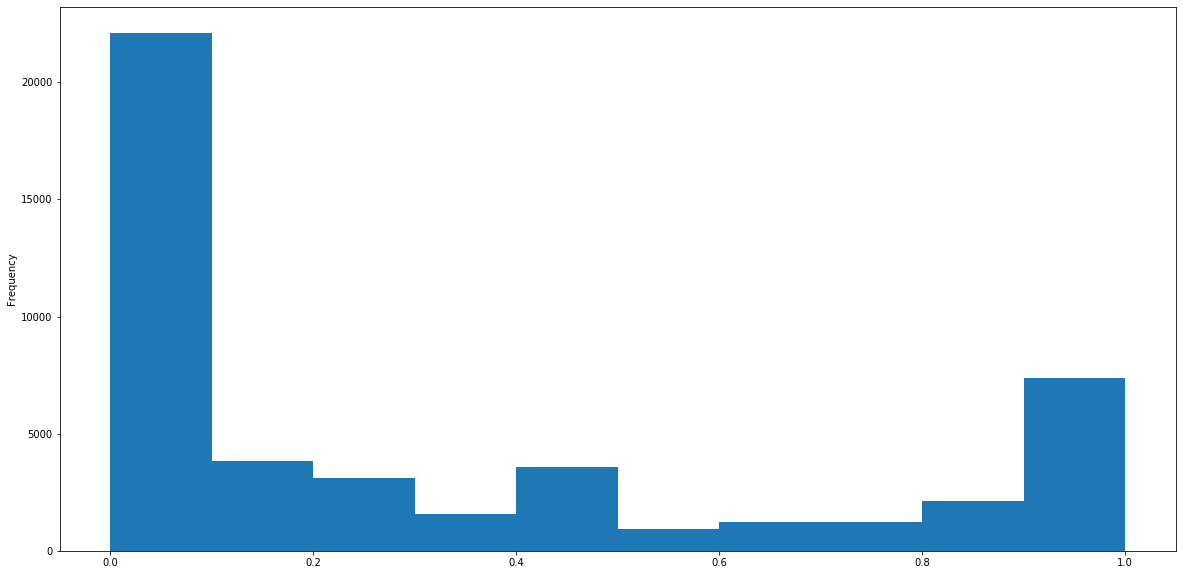

In [52]:
plt = listings_merge.available_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even in a low season like winter, there seems to be low availability.</p>

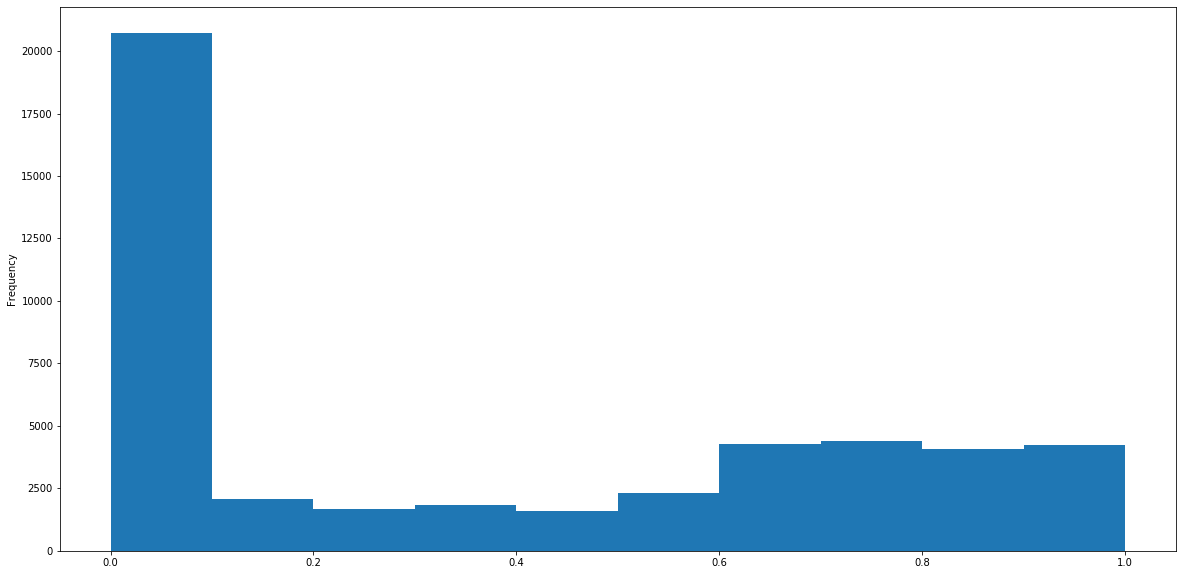

In [53]:
plt = listings_merge.available_winter_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Plotting the log of the minimum nights required we see that it approximates an exponential distribution.</p>

1.000000     10982
2.000000     10614
3.000000      7123
30.000000     3630
4.000000      2986
             ...  
13.753425        1
7.934247         1
1.945205         1
1.339726         1
21.005479        1
Name: min_nights_year_avg, Length: 1517, dtype: int64
30.000000    3630
7.000000     1860
6.000000      684
14.000000     501
10.000000     446
             ... 
6.906849        1
28.884932       1
25.232877       1
6.347945        1
5.778082        1
Name: min_nights_year_avg, Length: 655, dtype: int64


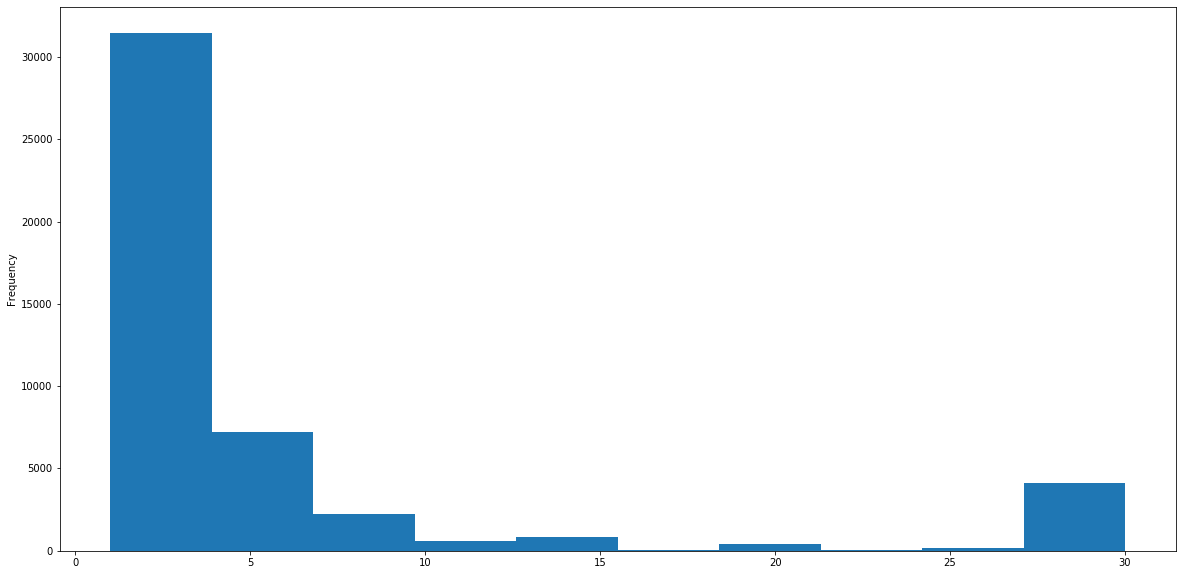

In [54]:
min_nights_75_perc = listings_merge.loc[listings_merge.min_nights_year_avg > 5].min_nights_year_avg.value_counts()
print(listings_merge.min_nights_year_avg.value_counts())
print(min_nights_75_perc)
plt = listings_merge.min_nights_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>There isn't much detail in plot of average prices over the year.  We can't plot the log of average prices due to some zero values that need to be cleaned up.</p>

150.000000    893
100.000000    814
200.000000    675
50.000000     551
60.000000     524
             ... 
108.857534      1
154.967123      1
159.232877      1
46.312329       1
39.654795       1
Name: price_year_avg, Length: 23085, dtype: int64
200.000000    675
250.000000    447
300.000000    237
225.000000    169
350.000000    164
             ... 
193.082192      1
322.027397      1
537.660274      1
208.501370      1
186.013699      1
Name: price_year_avg, Length: 6595, dtype: int64


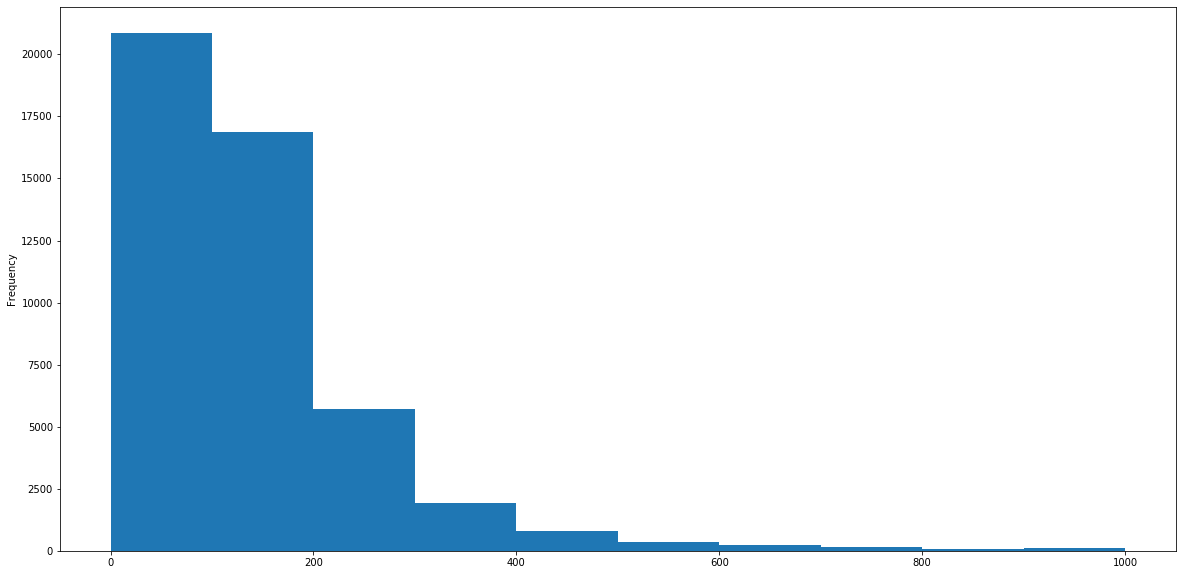

In [55]:
price_75_perc = listings_merge.loc[listings_merge.price_year_avg > 180].price_year_avg.value_counts()
print(listings_merge.price_year_avg.value_counts())
print(price_75_perc)
plt = listings_merge.price_year_avg.plot(kind='hist', figsize=(20, 10))

<br/>
<p>Use a similar method as with the <b>listings_clean</b> table to average over a 200 m radius from listings that have 0, missing, or outlier values for prices.</p>

In [60]:
# print(listings_merge.columns[384], listings_merge.columns[391], listings_merge.columns[4], listings_merge.columns[5])

print(listings_merge.columns[164], listings_merge.columns[171], listings_merge.columns[4], listings_merge.columns[5])

price_year_avg price_dec_avg latitude longitude


<br/>
<p>Similar to how we handled <b>bedrooms</b>, we will average price over 200m radius from listings that have 0 or NaN values.  Again we will not consider <b>room_type</b></p>

In [61]:
# https://gizmodo.com/how-precise-is-one-degree-of-longitude-or-latitude-1631241162
# averaging over approximate radius of 200 m from listings
# that have 0, NaN, or greater than threshold price values

lat_diff = 0.002
long_diff = 0.002
def avg_of_neighbors_2(row, col_name, col_index):
    item = row[col_index]
    lat = row[4]
    long = row[5]
    if math.isnan(item) or item == 0:
        item = listings_merge[col_name].loc[(listings_clean.latitude > lat - lat_diff) \
            & (listings_merge.latitude < lat + lat_diff) \
            & (listings_merge.longitude > long - long_diff) \
            & (listings_merge.longitude < long + long_diff)].groupby(by=listings_merge.neighbourhood).mean().round()[0]
        row[col_index] = item
    return row

listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_year_avg', col_index=164, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_winter_avg', col_index=165, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_spring_avg', col_index=166, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_summer_avg', col_index=167, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_fall_avg', col_index=168, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jan_avg', col_index=169, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_jun_avg', col_index=170, axis=1)
listings_merge = listings_merge.apply(avg_of_neighbors_2, col_name='price_dec_avg', col_index=171, axis=1)

<br/>
<p>After some cleanup and taking the log of prices averaged over the year, we see an approximate normal distribution.</p>

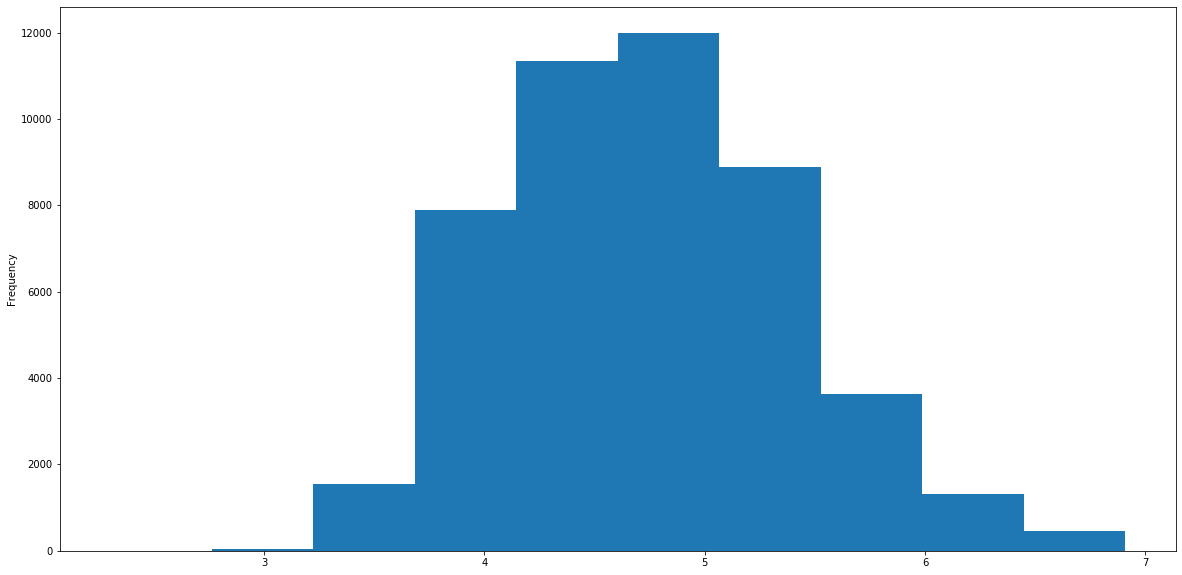

In [62]:
plt = np.log(listings_merge.price_year_avg).plot(kind='hist', figsize=(20, 10))

<br/>
<p>Even after the cleaning process, we find that there is still a missing <b>price_fall_avg</b> value.  Averaging over nearest neighbors didn't catch everything!</p>

In [63]:
listings_merge.info()
listings_merge.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47134 entries, 0 to 48913
Columns: 172 entries, id to price_dec_avg
dtypes: float64(31), int64(136), object(5)
memory usage: 63.5+ MB


,id,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,reviews_per_month,...,min_nights_jun_avg,min_nights_dec_avg,price_year_avg,price_winter_avg,price_spring_avg,price_summer_avg,price_fall_avg,price_jan_avg,price_jun_avg,price_dec_avg
count,4.713400e+04,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,38218.000000,...,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000,47134.000000
mean,2.103222e+07,40.728482,-73.950377,2.863920,1.135147,1.173569,1.529618,25.725697,94.000336,1.418428,...,5.618383,5.558512,143.421665,138.556556,143.602661,145.946891,145.497328,135.532355,146.440235,144.306909
std,1.236688e+07,0.055183,0.047725,1.815014,0.386755,0.727232,1.035513,48.180275,7.487219,1.680114,...,8.193094,8.073898,115.492983,110.213940,117.543871,119.136305,118.855495,108.074091,120.722377,116.890361
min,2.595000e+03,40.499790,-74.247870,1.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.010000,...,1.000000,1.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,9.926413e+06,40.689023,-73.982410,2.000000,1.000000,1.000000,1.000000,1.000000,93.000000,0.190000,...,1.533333,1.645161,70.000000,68.980556,70.000000,70.000000,70.000000,67.879032,70.000000,70.000000
50%,2.109668e+07,40.722285,-73.954680,2.000000,1.000000,1.000000,1.000000,6.000000,94.000000,0.750000,...,2.800000,2.709677,110.000000,106.761111,109.342391,110.000000,110.000000,104.354839,110.000000,110.000000
75%,3.213642e+07,40.763100,-73.933742,4.000000,1.000000,1.000000,2.000000,27.000000,99.000000,2.150000,...,5.000000,5.000000,177.750000,174.855556,177.000000,180.000000,180.000000,169.000000,180.000000,179.000000
max,4.058402e+07,40.916860,-73.712990,16.000000,5.000000,10.000000,12.000000,675.000000,100.000000,19.950000,...,30.000000,30.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000


In [64]:
listings_merge_backup = listings_merge

In [65]:
listings_merge = listings_merge_backup

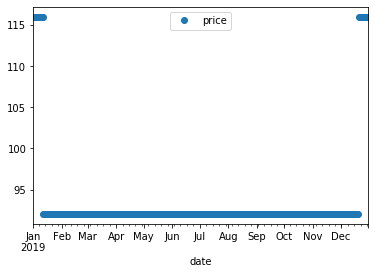

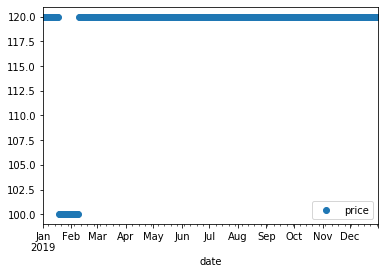

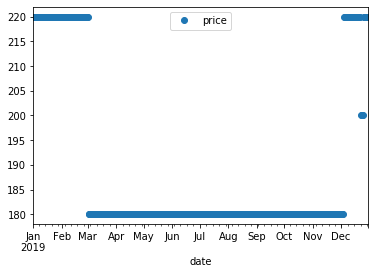

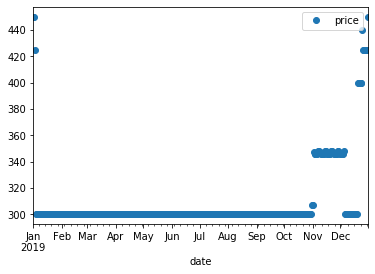

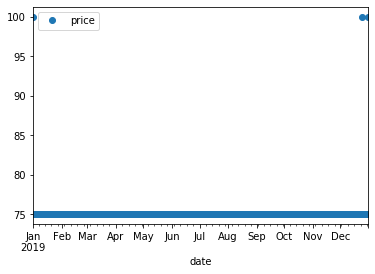

In [66]:
#Bronx 71812, Brooklyn 8490, Manhattan 9657, Queens 45910, Staten Island 225976
# listings_clean.loc[
#     (listings_clean.neighbourhood_group == 'Staten Island') &
#     (listings_clean.room_type == 'Entire home/apt')].head()
listings_ids = [71812, 8490, 9657, 45910, 225976]
for listing_id in listings_ids:
    calendar_clean.loc[calendar_clean.listing_id == listing_id].sort_values(by='date').plot(
        x='date', y='price', style='o'
    )

<br/>
<p>Let's do a final check for any correlated features.</p>

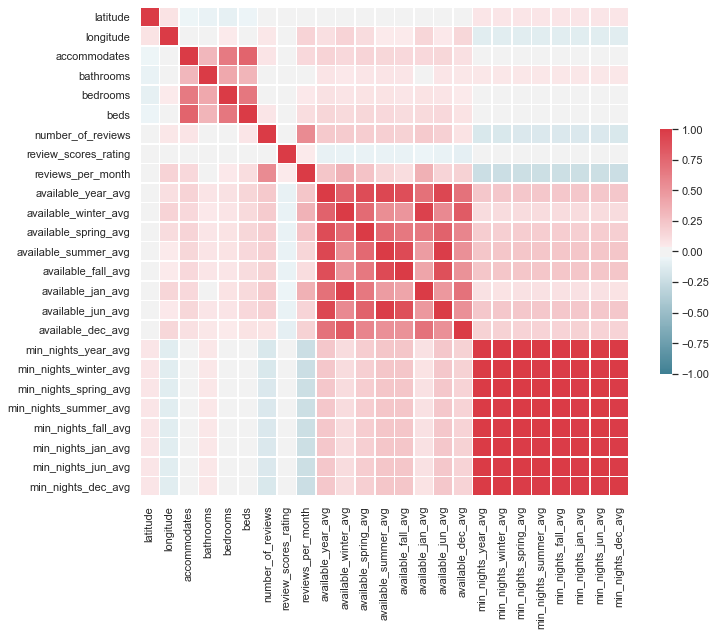

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

features = listings_merge[[
    'summary', 'neighbourhood', 'neighbourhood_group', 'latitude', 'longitude',
    'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
    'amenities', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg', 'available_fall_avg',
    'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg', 'min_nights_fall_avg',
    'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg'
]]

fig, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(features.corr(), cmap=cmap, vmax=1, vmin=-1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

<p>We can see that <b>beds</b> and <b>accommodates</b> are heavily correlated with <b>bedrooms</b>.  We can drop those columns.</p>

In [68]:
listings_merge = listings_merge.drop(['beds', 'accommodates'], axis=1)
listings_merge = listings_merge.drop(['id', 'room_type', 'neighbourhood', 'neighbourhood_group'], axis=1)
listings_merge = listings_merge.drop(['reviews_per_month'], axis=1)
listings_merge = listings_merge.drop(['number_of_reviews'], axis=1)
listings_merge = listings_merge.drop(['summary', 'amenities'], axis=1)

# listings_merge = listings_merge.drop(['review_scores_rating'], axis=1)
# listings_merge = listings_merge.drop(
#     ['available_year_avg', 'available_winter_avg', 'available_spring_avg',
#      'available_summer_avg', 'available_fall_avg', 'available_jan_avg',
#      'available_jun_avg','available_dec_avg'], axis=1)

In [69]:
X_base = listings_merge.drop([
    'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
    'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
    'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
    'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
    'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
    'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
], axis=1)
X_base.shape

(47134, 138)

<p>Perhaps we can add more features like monthly or holiday averages for availability, minimum nights required, and price, but that would make the table size explode!<p>

<h2>Modeling data with prices as target labels</h2>

<p>Now that we've cleaned up the data, let's look at several possible models of linear and non-linear type.  We will use average price of each listing over the year 2019, as well as seasonal average price as the target labels.  The easiest ones to get started with are Linear Regression and Random Forest.</p>

In [73]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)
    print('Target label:', combo[2])
    
    clf = LinearRegression()
    clf.fit(X_train, y_train)
    print("Linear regression R^2:", clf.score(X_test, y_test))
    print("Linear regression MAE:", mean_absolute_error(y_test, clf.predict(X_test)))

Target label: price_year_avg
Linear regression R^2: -45309022.10863838
Linear regression MAE: 7201.712377588719
Target label: price_summer_avg
Linear regression R^2: -100206867490.63133
Linear regression MAE: 348532.17829071207


In [71]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)
    print('Target label:', combo[2])
    
    clf = RandomForestRegressor()
    clf.fit(X_train, y_train)
    print("Random forest R^2:", clf.score(X_test, y_test))
    print("Random forest MAE:", mean_absolute_error(y_test, clf.predict(X_test)))

Target label: price_year_avg
Random forest R^2: 0.6660642017028623
Random forest MAE: 37.6946376698379
Target label: price_summer_avg
Random forest R^2: 0.6602965061077284
Random forest MAE: 39.245405653207


<p>We can see that Random Forest performs much better than Linear Regression in terms of R<sup>2</sup> score.</p>

<br/>
<p>Perhaps there will be an incremental improvement in R<sup>2</sup> by using Gradient Boosting (XGBoost in this case).</p>

In [72]:
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
    ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    X_train, X_test, y_train, y_test = train_test_split(X_base, y, test_size=.25, random_state=42, shuffle=True)

    clf = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=0.1,
        max_depth=8,
        n_estimators=200,
        cv=5
    )

    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('Gradient boost R^2:', clf.score(X_test, y_test))
    print('Gradient boost MAE:', mean_absolute_error(y_test, clf.predict(X_test)))

Target label: price_year_avg
Gradient boost R^2: 0.690799566799508
Gradient boost MAE: 36.209078896154
Target label: price_summer_avg
Gradient boost R^2: 0.6813725798412273
Gradient boost MAE: 38.099903860904


<p>We get decent scores from a Gradient Boost model.</p>

<p>Will polynomial regression provide any benefit?  Let's find out.</p>

<p>It's odd that Polynomial Feature Transform + Linear Regresssion has such terrible scores.  Second degree Polynomial Feature Transform + Gradient Boosting performs close to Gradient Boosting alone.</p>

<p>Now apply deep learning with a neural network made up mainly of dense layers.</p>

In [113]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

combo_list = [
    ['available_year_avg', 'min_nights_year_avg', 'price_year_avg'],
#     ['available_winter_avg', 'min_nights_winter_avg', 'price_winter_avg'],
#     ['available_spring_avg', 'min_nights_spring_avg', 'price_spring_avg'],
#     ['available_summer_avg', 'min_nights_summer_avg', 'price_summer_avg'],
#     ['available_fall_avg', 'min_nights_fall_avg', 'price_fall_avg'],
#     ['available_jan_avg', 'min_nights_jan_avg', 'price_jan_avg'],
#     ['available_jun_avg', 'min_nights_jun_avg', 'price_jun_avg'],
#     ['available_dec_avg', 'min_nights_dec_avg', 'price_dec_avg']
]

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=2)
adam = Adam(lr=0.001)
sgd = SGD(lr=0.001)

def base_model():
    model = Sequential()
    model.add(Dense(150, input_dim=134, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=adam, metrics=['mae'])
    return model

for combo in combo_list:
    X_base = listings_merge.drop([
        'price_year_avg', 'price_winter_avg', 'price_spring_avg', 'price_summer_avg', 'price_fall_avg',
        'price_jan_avg', 'price_jun_avg', 'price_dec_avg',
        'available_year_avg', 'available_winter_avg', 'available_spring_avg', 'available_summer_avg',
        'available_fall_avg', 'available_jan_avg', 'available_jun_avg', 'available_dec_avg',
        'min_nights_year_avg', 'min_nights_winter_avg', 'min_nights_spring_avg', 'min_nights_summer_avg',
        'min_nights_fall_avg', 'min_nights_jan_avg', 'min_nights_jun_avg', 'min_nights_dec_avg',
    ], axis=1)
    X_base[combo[0]] = listings_merge[combo[0]]
    X_base[combo[1]] = listings_merge[combo[1]]
    y = listings_merge[combo[2]]
    
    scaler = MinMaxScaler()
    X_scale = scaler.fit_transform(X_base.values)
    
    X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=.25, random_state=42, shuffle=True)

    
    clf = KerasRegressor(build_fn=base_model, epochs=100, batch_size=50, verbose=1, callbacks=[es])
#     kfold = KFold(n_splits=5)
#     results = cross_val_score(clf, X_train, y_train, cv=kfold)
#     print(results)

    clf.fit(X_train, y_train)
    print('Target label:', combo[2])
    print('Neural network MAE:', mean_absolute_error(y_test, clf.predict(X_test)))

Train on 35350 samples
Epoch 1/100
35350/35350 [==============================] - 2s 47us/sample - loss: 11453.3201 - mae: 66.0627
Epoch 2/100
35350/35350 [==============================] - 2s 47us/sample - loss: 8040.4103 - mae: 54.35880s - loss: 8057.6240 - mae: 54.4
Epoch 3/100
35350/35350 [==============================] - 1s 35us/sample - loss: 7464.0042 - mae: 52.1215
Epoch 4/100
35350/35350 [==============================] - 1s 36us/sample - loss: 7166.7683 - mae: 50.7231
Epoch 5/100
35350/35350 [==============================] - 1s 34us/sample - loss: 6922.3566 - mae: 50.07280s - loss: 6873.2019 -
Epoch 6/100
35350/35350 [==============================] - 1s 35us/sample - loss: 6756.9482 - mae: 49.4667
Epoch 7/100
35350/35350 [==============================] - 1s 32us/sample - loss: 6646.7719 - mae: 48.8562
Epoch 8/100
35350/35350 [==============================] - 1s 38us/sample - loss: 6482.8879 - mae: 48.5152
Epoch 9/100
35350/35350 [==============================] - 2s 45us

<p>The best mean absolute error for average nightly price that can be achieved so far is around 42.  The mean of the average nightly price over the year is around 143.</p>